In [1]:
from control import NonlinearIOSystem, input_output_response, InterconnectedSystem
from numpy import linspace, matrix, arctan2

from matplotlib.pyplot import figure, style
from matplotlib import rcParams

style.use("dark_background")

rcParams["figure.facecolor"] = (43/256, 43/256, 43/256)
rcParams["axes.facecolor"]   = (43/256, 43/256, 43/256)
rcParams["legend.facecolor"] = (43/256, 43/256, 43/256)
rcParams["axes.grid"]        = True
rcParams["lines.linewidth"]  = 2.5
rcParams["grid.linewidth"]   = 0.5

In [8]:
def logic_ctl(t, x, u, params):
    
    return [s, d]
    
def driver_ctl(t, x, u, params):
    nom_sec = params.get("secuencia_pasos", "HSD")
    
    if   nom_sec ==  "WD":
        # Wave drive
        secuencia = [[1,0,0,0], [0,0,1,0], [0,1,0,0], [0,0,0,1]]
        
    elif nom_sec == "FSD":
        # Full step drive
        secuencia = [[1,0,1,0], [0,1,1,0], [0,1,0,1], [1,0,0,1]]
        
    elif nom_sec == "HSD":
        # Half step drive
        secuencia = [[1,0,0,0],[1,0,1,0],[1,1,1,0],[0,1,1,0],
                     [0,1,1,1],[0,1,0,1],[0,0,0,1],[1,0,0,1]]
        
    δ = 0.1
    n = t/δ
    
    m1, m2, m3, m4 = secuencia[int(n%len(secuencia))]
    
    return [m1, m2, m3, m4]

def driver_pot(t, x, u, params):
    V = params.get("Vin", 5)
    
    m1, m2, m3, m4 = u
    
    v1 = (m1 - m2)*V
    v2 = (m3 - m4)*V
    
    return [v1, v2]

def coil_elec(t, x, u, params):
    L = params.get("L", 0.01)
    R = params.get("R", 1.2)
    
    v1, v2 = u
    i1, i2 = x
    
    di1 = (1/L)*v1 - (R/L)*i1
    di2 = (1/L)*v2 - (R/L)*i2
    
    return [di1, di2]

def coil_torque(t, x, u, params):
    from numpy import arctan2, degrees, sqrt, sin, radians
    Km = params.get("Km", 20)
    n_polos = params.get("n_polos", 50)
    τmax = params.get("τmax", 0.02)
    nom_sec = params.get("secuencia_pasos", "HSD")
    
    i1, i2, θ = u
    
    ϕ = degrees(arctan2(i2, i1)) % 360
        
    i = sqrt(i1**2 + i2**2)
    τ = min(max(Km*i*sin(radians(ϕ - (θ*n_polos)%360)), -τmax), τmax)
    
    return τ

def motor_mech(t, x, u, params):
    J = params.get("J", 0.00002)
    B = params.get("B", 0.001)
    
    τ = u
    θ = x
    
    dθ = (1/J)*τ - (B/J)*θ
    
    return dθ

In [9]:
io_drv_ctl = NonlinearIOSystem(None, driver_ctl, inputs=("u"),
                               outputs=("m1", "m2", "m3", "m4"),
                               name="driver_ctl")

io_drv_pot = NonlinearIOSystem(None, driver_pot,
                               inputs=("m1", "m2", "m3", "m4"),
                               outputs=("v1", "v2"),
                               name="driver_pot")

io_coil_elec = NonlinearIOSystem(coil_elec, None,
                                 inputs=("v1", "v2"),
                                 outputs=("i1", "i2"),
                                 states=("i1", "i2"),
                                 name="coil_elec")

io_coil_torque = NonlinearIOSystem(None, coil_torque,
                                   inputs=("i1", "i2", "θ"),
                                   outputs=("τ"),
                                   name="coil_torque")

io_motor_mech = NonlinearIOSystem(motor_mech, None,
                                  inputs=("τ"),
                                  outputs=("θ"),
                                  states=("θ"),
                                  name="motor_mech")

In [10]:
motor = InterconnectedSystem(syslist=(io_drv_ctl, io_drv_pot, io_coil_elec,
                                      io_coil_torque, io_motor_mech),
                             connections=(("coil_elec.v1", "driver_pot.v1"),
                                          ("coil_elec.v2", "driver_pot.v2"),
                                          ("driver_pot.m1", "driver_ctl.m1"),
                                          ("driver_pot.m2", "driver_ctl.m2"),
                                          ("driver_pot.m3", "driver_ctl.m3"),
                                          ("driver_pot.m4", "driver_ctl.m4"),
                                          ("coil_torque.i1", "coil_elec.i1"),
                                          ("coil_torque.i2", "coil_elec.i2"),
                                          ("coil_torque.θ", "motor_mech.θ"),
                                          ("motor_mech.τ", "coil_torque.τ")),
                             inplist=("driver_ctl.u"),
                             outlist=("coil_elec.i1", "coil_elec.i2",
                                      "driver_ctl.m1", "driver_ctl.m2",
                                      "driver_ctl.m3", "driver_ctl.m4",
                                      "coil_torque.τ", "motor_mech.θ"))

In [11]:
ts = linspace(0, 10, 1000)

In [12]:
t, y = input_output_response(sys=motor, T=ts, U=ts, X0=[0,0,0], params={"secuencia_pasos":"WD"})

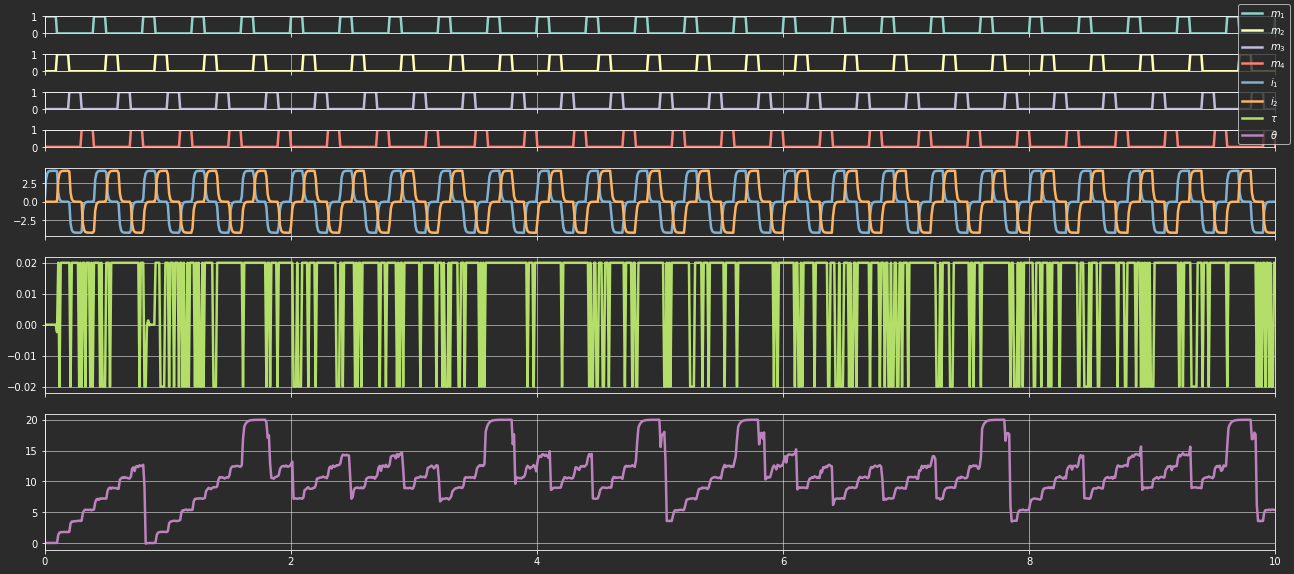

In [13]:
fig = figure(figsize=(18,8))
ax1, ax2, ax3, ax4, ax5, ax6, ax7 = fig.subplots(7, 1, sharex='all', gridspec_kw={'height_ratios': [1, 1, 1, 1, 4, 8, 8]})
cycle = rcParams['axes.prop_cycle'].by_key()['color']

ax1.plot(t, y[2], c=cycle[0], label=r"$m_1$")
ax2.plot(t, y[4], c=cycle[1], label=r"$m_2$")
ax3.plot(t, y[3], c=cycle[2], label=r"$m_3$")
ax4.plot(t, y[5], c=cycle[3], label=r"$m_4$")

ax5.plot(t, y[0], c=cycle[4], label=r"$i_1$")
ax5.plot(t, y[1], c=cycle[5], label=r"$i_2$")

ax6.plot(t, y[6], c=cycle[6], label=r"$\tau$")
ax7.plot(t, y[7], c=cycle[7], label=r"$\theta$")

ax1.set_ylim(0, 1)
ax2.set_ylim(0, 1)
ax3.set_ylim(0, 1)
ax4.set_ylim(0, 1)
ax7.set_xlim(min(t), max(t))
fig.legend()
fig.tight_layout();

In [14]:
t, x = input_output_response(sys=motor, T=ts, U=ts, X0=[0,0,0], params={"secuencia_pasos":"FSD"})

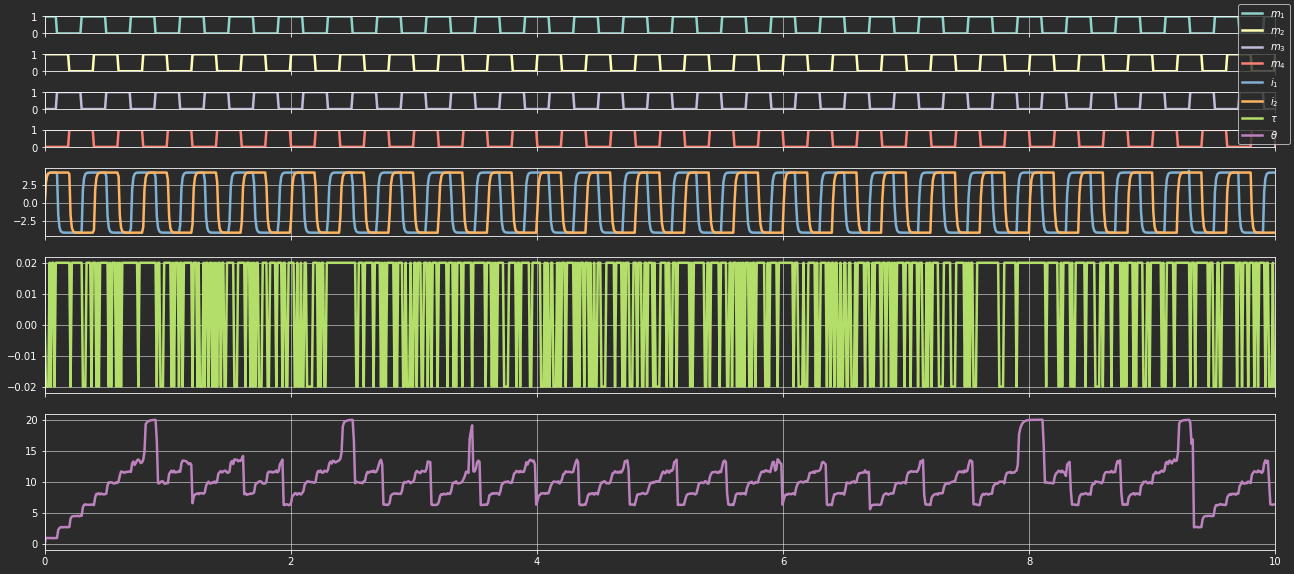

In [15]:
fig = figure(figsize=(18,8))
ax1, ax2, ax3, ax4, ax5, ax6, ax7 = fig.subplots(7, 1, sharex='all', gridspec_kw={'height_ratios': [1, 1, 1, 1, 4, 8, 8]})
cycle = rcParams['axes.prop_cycle'].by_key()['color']

ax1.plot(t, x[2], c=cycle[0], label=r"$m_1$")
ax2.plot(t, x[4], c=cycle[1], label=r"$m_2$")
ax3.plot(t, x[3], c=cycle[2], label=r"$m_3$")
ax4.plot(t, x[5], c=cycle[3], label=r"$m_4$")

ax5.plot(t, x[0], c=cycle[4], label=r"$i_1$")
ax5.plot(t, x[1], c=cycle[5], label=r"$i_2$")

ax6.plot(t, x[6], c=cycle[6], label=r"$\tau$")
ax7.plot(t, x[7], c=cycle[7], label=r"$\theta$")

ax1.set_ylim(0, 1)
ax2.set_ylim(0, 1)
ax3.set_ylim(0, 1)
ax4.set_ylim(0, 1)

ax7.set_xlim(min(t), max(t))
fig.legend()
fig.tight_layout();

In [16]:
t, w = input_output_response(sys=motor, T=ts, U=ts, X0=[0,0,0], params={"secuencia_pasos":"HSD"})

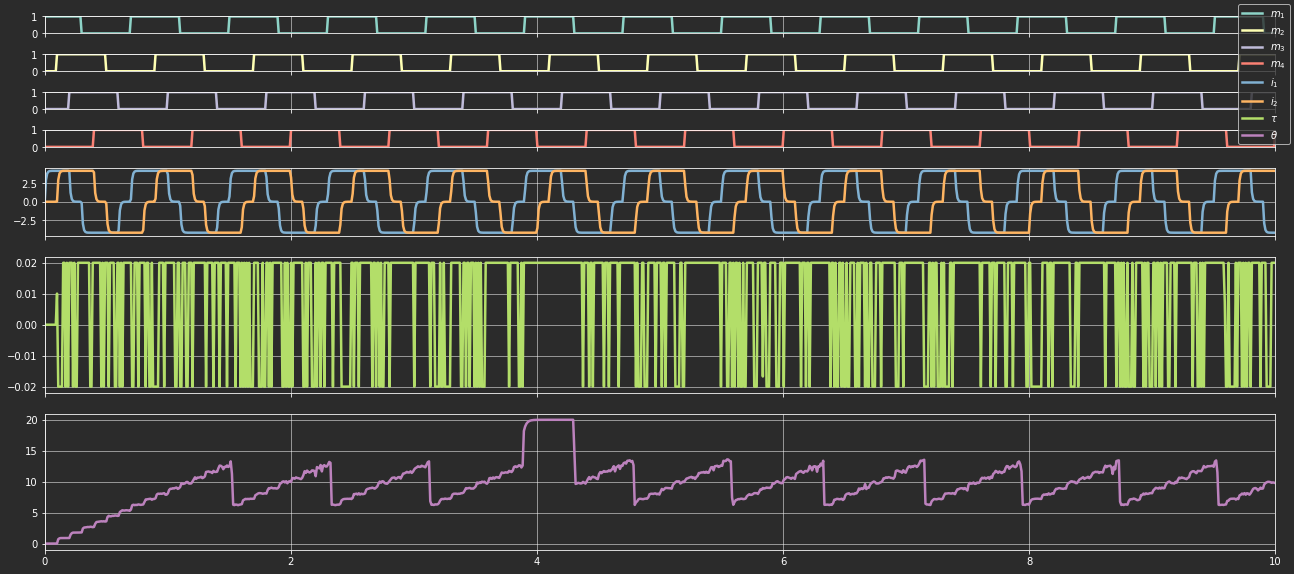

In [17]:
fig = figure(figsize=(18,8))
ax1, ax2, ax3, ax4, ax5, ax6, ax7 = fig.subplots(7, 1, sharex='all', gridspec_kw={'height_ratios': [1, 1, 1, 1, 4, 8, 8]})
cycle = rcParams['axes.prop_cycle'].by_key()['color']

ax1.plot(t, w[2], c=cycle[0], label=r"$m_1$")
ax2.plot(t, w[4], c=cycle[1], label=r"$m_2$")
ax3.plot(t, w[3], c=cycle[2], label=r"$m_3$")
ax4.plot(t, w[5], c=cycle[3], label=r"$m_4$")

ax5.plot(t, w[0], c=cycle[4], label=r"$i_1$")
ax5.plot(t, w[1], c=cycle[5], label=r"$i_2$")

ax6.plot(t, w[6], c=cycle[6], label=r"$\tau$")
ax7.plot(t, w[7], c=cycle[7], label=r"$\theta$")

ax1.set_ylim(0, 1)
ax2.set_ylim(0, 1)
ax3.set_ylim(0, 1)
ax4.set_ylim(0, 1)

ax7.set_xlim(min(t), max(t))
fig.legend()
fig.tight_layout();